# 試験環境

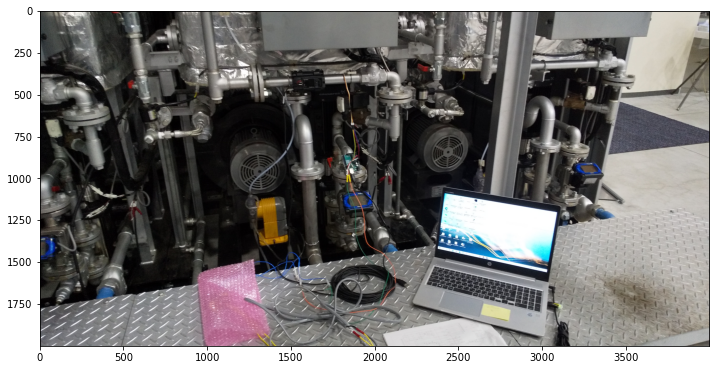

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.figure(figsize=(12,10))
plt.imshow(mpimg.imread("./test_pic/DSC_2149.jpg"))

### 今回の試験対象はSE-2000APGの給水配管。(トレセン設置)
### 運転はせず、給水ポンプも動かさず、水頭圧で配管に水を通した。
### （モータや燃焼の振動が無い状態で試験を行った。）
### 流量調整はバルブの開度で行った。
### 測定時の流量範囲は0～2500L/hほど。

## 測定ポイント

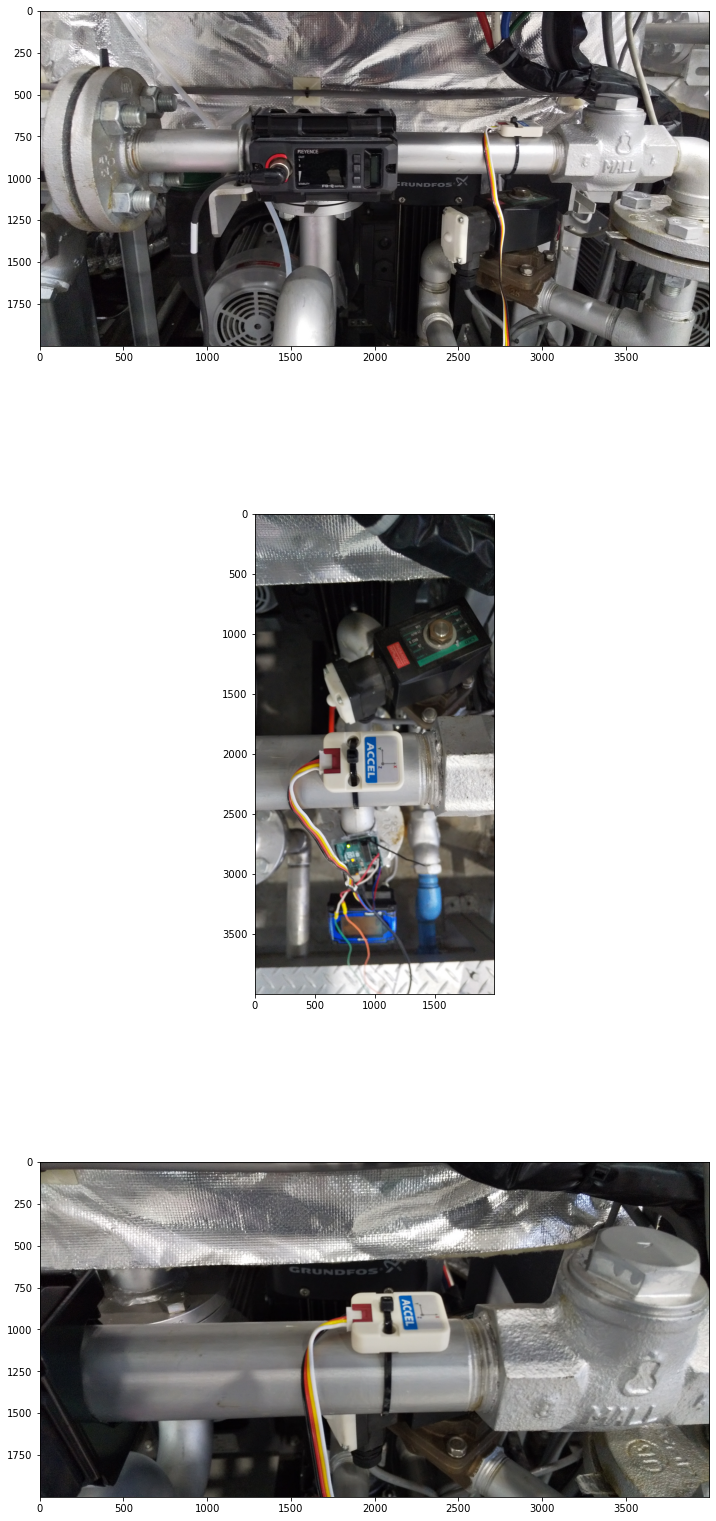

In [2]:
plt.figure(figsize=(12,30))
plt.subplot(3,1,1)
plt.imshow(mpimg.imread("./test_pic/DSC_2148.jpg"))
plt.subplot(3,1,2)
plt.imshow(mpimg.imread("./test_pic/DSC_2150.jpg"))
plt.subplot(3,1,3)
plt.imshow(mpimg.imread("./test_pic/DSC_2151.jpg"))

### ボイラ技術部から借りた瞬時流量計から瞬時流量(0-7200L/h)を4-20mAで取る。シャント抵抗値は249.3Ω。
### 加速度センサADXL345（設定：サンプリング100Hz、±4g、arduinoとの通信間隔は100ms、PCへのデータ
### 送信間隔は200ms）を使用する。インターフェースはI2Cバス。PCとの接続はUART(USBケーブル)を使う。
### 加速度センサは横方向に水平に伸びる給水配管の上部に取り付け、配管に沿った方向がX軸、配管の
### 横垂直方向がY軸、配管の縦垂直方向がZ軸となる様に配置。


## 取得したデータを確認してみる。

In [3]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [4]:
os.getcwd()

'C:\\Users\\User\\Desktop\\1_data'

In [5]:
#ファイル選択
df_recivedata = pd.read_csv(r"recivedata0202.csv")

#頭と尻の10行づつ表示
display(df_recivedata.head(5))
display(df_recivedata.tail(5))

,Date1,Date2,X,Y,Z,moment,LSB,X_bound,Y_bound,Z_bound
0,2021/9/9 16:58,730497 us,5,6,115,21802,452,0,0,0
1,2021/9/9 16:58,930139 us,7,12,117,21978,454,2,6,2
2,2021/9/9 16:58,127066 us,5,8,117,22065,455,-2,-4,0
3,2021/9/9 16:58,328604 us,1,5,118,21274,446,-4,-3,1
4,2021/9/9 16:58,529101 us,3,7,114,21538,449,2,2,-4


,Date1,Date2,X,Y,Z,moment,LSB,X_bound,Y_bound,Z_bound
11147,2021/9/10 11:22,199348 us,5,9,116,0,204,1,1,0
11148,2021/9/10 11:22,403028 us,5,9,116,0,204,0,0,0
11149,2021/9/10 11:22,590568 us,5,9,116,0,204,0,0,0
11150,2021/9/10 11:22,793159 us,4,8,116,0,204,-1,-1,0
11151,2021/9/10 11:22,996237 us,4,9,116,0,204,0,1,0


## 尚、X_bound,Y_bound,Z_boundは収集後追加したカラム。前回の値との差を示す値。

## ここで欠損値がないか確認してみる。

In [6]:
df_recivedata.count()

Date1      11152
Date2      11152
X          11152
Y          11152
Z          11152
moment     11152
LSB        11152
X_bound    11152
Y_bound    11152
Z_bound    11152
dtype: int64

## 必要ない日付を消す

In [7]:
df_recivedata = df_recivedata.drop(["Date1", "Date2"], axis = 1)

df_recivedata

,X,Y,Z,moment,LSB,X_bound,Y_bound,Z_bound
0,5,6,115,21802,452,0,0,0
1,7,12,117,21978,454,2,6,2
2,5,8,117,22065,455,-2,-4,0
3,1,5,118,21274,446,-4,-3,1
4,3,7,114,21538,449,2,2,-4
...,...,...,...,...,...,...,...,...
11147,5,9,116,0,204,1,1,0
11148,5,9,116,0,204,0,0,0
11149,5,9,116,0,204,0,0,0
11150,4,8,116,0,204,-1,-1,0


## 散布図行列を書いてみる

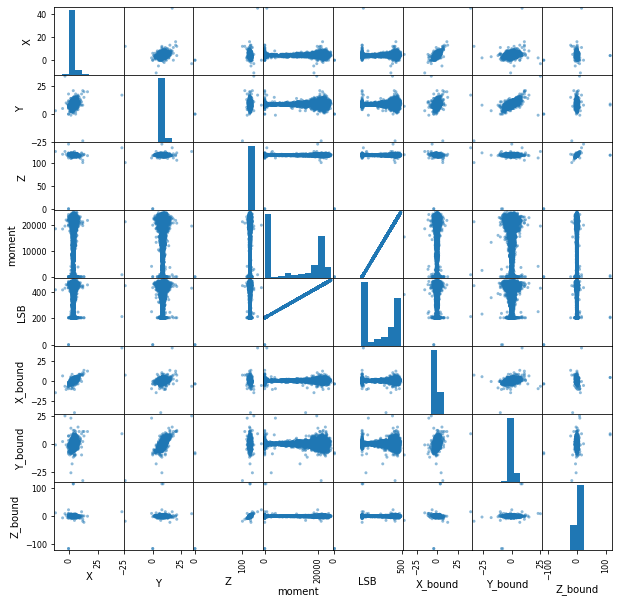

In [8]:
pd.plotting.scatter_matrix(df_recivedata, figsize=(10,10))
plt.show()

## 相関係数を確認する。

In [9]:
# 相関係数を確認
df_recivedata.corr()

,X,Y,Z,moment,LSB,X_bound,Y_bound,Z_bound
X,1.000000,0.273414,0.009710,0.167609,0.168926,0.671647,0.186588,-0.000757
Y,0.273414,1.000000,0.101304,0.059056,0.061092,0.208719,0.699137,0.060500
Z,0.009710,0.101304,1.000000,0.016303,0.036651,0.003105,0.060404,0.706013
moment,0.167609,0.059056,0.016303,1.000000,0.999710,-0.006375,-0.002972,-0.000429
LSB,0.168926,0.061092,0.036651,0.999710,1.000000,-0.005382,-0.001532,0.013974
X_bound,0.671647,0.208719,0.003105,-0.006375,-0.005382,1.000000,0.288074,0.001614
Y_bound,0.186588,0.699137,0.060404,-0.002972,-0.001532,0.288074,1.000000,0.086094
Z_bound,-0.000757,0.060500,0.706013,-0.000429,0.013974,0.001614,0.086094,1.000000


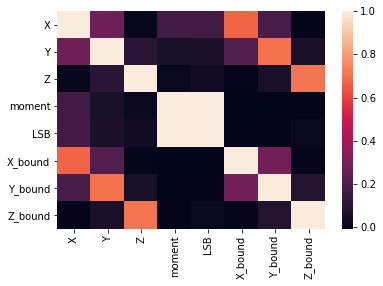

In [10]:
# 相関係数をヒートマップにして可視化
sns.heatmap(df_recivedata.corr())
plt.show()

## 瞬時流量とXYZ軸の振動値に相関は見られない。
## 流量が増えると振動の振幅が増える事が判った。特にY軸(水管に対して横垂直方向)が顕著。